1. Recall of linear classifier
2. MLP with scikit-learn
3. MLP with pytorch
4. Test several MLP architectures
5. Limits of MLP

In [1]:
%matplotlib inline
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.neural_network import MLPClassifier
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models

import time
import copy

#from sklearn.datasets import fetch_openml

#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

from pathlib import Path
import matplotlib.pyplot as plt
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Dataset: MNIST Handwritten Digit Recognition

In [2]:
WD = os.path.join(Path.home(), "data", "pystatml", "dl_mnist_pytorch")
os.makedirs(WD, exist_ok=True)
os.chdir(WD)
print("Working dir is:", os.getcwd())
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

Working dir is: /root/data/pystatml/dl_mnist_pytorch


In [3]:
def load_mnist(batch_size_train, batch_size_test):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.1307,), (0.3081,)) # Mean and Std of the MNIST dataset
                                                    ])),
        batch_size=batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([transforms.ToTensor(),
                                                                          transforms.Normalize((0.1307,), (0.3081,)) # Mean and Std of the MNIST dataset
                                                                         ])),
        batch_size=batch_size_test, shuffle=True)
    return train_loader, val_loader

In [4]:
train_loader, val_loader = load_mnist(64, 10000)
dataloaders = dict(train=train_loader, val=val_loader)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [5]:
# Info about the dataset
D_in = np.prod(dataloaders["train"].dataset.data.shape[1:])
D_out = len(dataloaders["train"].dataset.targets.unique())
print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10


In [6]:
batch_idx, (example_data, example_targets) = next(enumerate(train_loader))
print("Train batch:", example_data.shape, example_targets.shape)
batch_idx, (example_data, example_targets) = next(enumerate(val_loader))
print("Val batch:", example_data.shape, example_targets.shape)


Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [7]:
def show_data_label_prediction(data, y_true, y_pred=None, shape=(2, 3)):
    y_pred = [None] * len(y_true) if y_pred is None else y_pred
    fig = plt.figure()
    for i in range(np.prod(shape)):
        plt.subplot(*shape, i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title("True: {} Pred: {}".format(y_true[i], y_pred[i]))
        plt.xticks([])
        plt.yticks([])

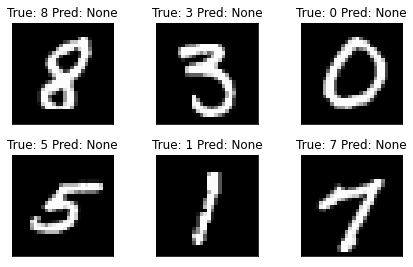

In [8]:
show_data_label_prediction(data=example_data, y_true=example_targets, y_pred=None,shape=(2, 3))

# Recall of linear classier
Binary logistic regression
1. neuron as output layer
        𝑓(𝑥) = 𝜎(𝑥𝑇𝑤)
# Softmax Classifier (Multinomial Logistic Regression)
   * Input 𝑥: a vector of dimension (0) (layer 0).
   * Ouput 𝑓(𝑥) a vector of (1) (layer 1) possible labels
* The model as (1) neurons as output layer
        𝑓(𝑥) = softmax(𝑥𝑇𝑊 + 𝑏)

In [9]:
X_train = train_loader.dataset.data.numpy()
#print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = train_loader.dataset.targets.numpy()
X_test = val_loader.dataset.data.numpy()
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = val_loader.dataset.targets.numpy()
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50., multi_class='multinomial', solver='sag', tol=0.1)
clf.fit(X_train, y_train)
#sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
print("Test score with penalty: %.4f" % score)

Test score with penalty: 0.9004


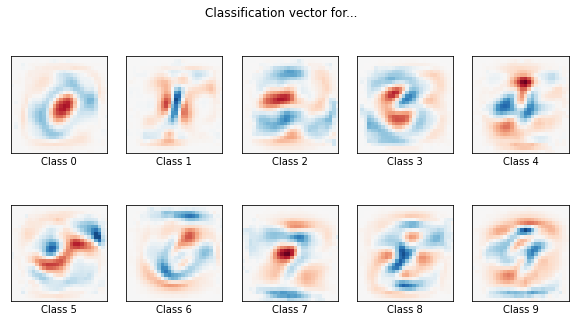

In [11]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
    cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
    
plt.suptitle('Classification vector for...')
plt.show()

# Model: Two Layer MLP

In [12]:
mlp = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=5, alpha=1e-4,
solver='sgd', verbose=10, tol=1e-4, random_state=1,
learning_rate_init=0.01, batch_size=64)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.28828673
Iteration 2, loss = 0.13388073
Iteration 3, loss = 0.09366379
Iteration 4, loss = 0.07317648
Iteration 5, loss = 0.05340251


MLPClassifier(batch_size=64, learning_rate_init=0.01, max_iter=5,
              random_state=1, solver='sgd', verbose=10)

In [13]:
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))
print("Coef shape=", len(mlp.coefs_))

Training set score: 0.989067
Test set score: 0.971900
Coef shape= 2


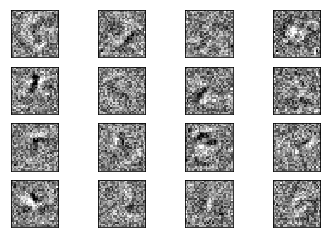

In [14]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
    vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

# MLP with pytorch

In [15]:
class TwoLayerMLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(TwoLayerMLP, self).__init__()
        self.d_in = d_in
        self.linear1 = nn.Linear(d_in, d_hidden)
        self.linear2 = nn.Linear(d_hidden, d_out)
    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.linear1(X)
        return F.log_softmax(self.linear2(X), dim=1)

In [16]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
    scheduler=None, log_interval=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])
    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train() # Set model to training mode
        else:
            model.eval() # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        nsamples = 0
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            nsamples += inputs.shape[0]
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if scheduler is not None and phase == 'train':
            scheduler.step()
        #nsamples = dataloaders[phase].dataset.data.shape[0]
        epoch_loss = running_loss / nsamples
        epoch_acc = running_corrects.double() / nsamples
        losses[phase].append(epoch_loss)
        accuracies[phase].append(epoch_acc)
        if log_interval is not None and epoch % log_interval == 0:
            print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                phase, epoch_loss, 100 * epoch_acc))
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    if log_interval is not None and epoch % log_interval == 0:
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [17]:
model = TwoLayerMLP(D_in, 50, D_out).to(device)
print(next(model.parameters()).is_cuda)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

False


In [18]:
# Explore the model
for parameter in model.parameters():
    print(parameter.shape)
    
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
num_epochs=1, log_interval=1)
print(next(model.parameters()).is_cuda)
torch.save(model.state_dict(), 'models/mod-%s.pth' % model.__class__.__name__)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])
Total number of parameters = 39760
Epoch 0/0
----------
train Loss: 0.4422 Acc: 87.88%
val Loss: 0.3047 Acc: 91.23%

Training complete in 0m 20s
Best val Acc: 91.23%
False


In [19]:
batch_idx, (example_data, example_targets) = next(enumerate(val_loader))
example_data = example_data.to(device)
with torch.no_grad():
    output = model(example_data).cpu()
example_data = example_data.cpu()

Output shape= torch.Size([10000, 10]) label shape= torch.Size([10000])
Accuracy = 91.23%


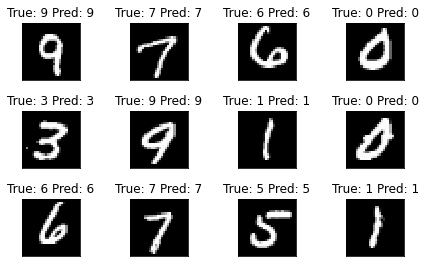

In [20]:
# print(output.is_cuda)
# Softmax predictions
preds = output.argmax(dim=1)
print("Output shape=", output.shape, "label shape=", preds.shape)
print("Accuracy = {:.2f}%".format((example_targets == preds).sum().item() * 100. / len(example_targets)))
show_data_label_prediction(data=example_data, y_true=example_targets, y_pred=preds,shape=(3, 4))

Nb errors = 877, (Error rate = 8.77%)


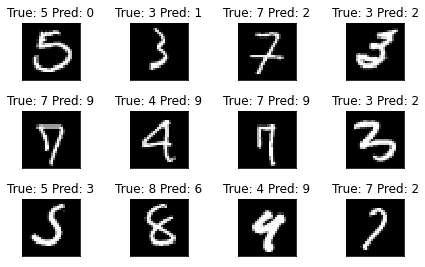

In [21]:
errors = example_targets != preds
#print(errors, np.where(errors))
print("Nb errors = {}, (Error rate = {:.2f}%)".format(errors.sum(), 100 * errors.sum().item() / len(errors)))
err_idx = np.where(errors)[0]
show_data_label_prediction(data=example_data[err_idx], y_true=example_targets[err_idx],
y_pred=preds[err_idx], shape=(3, 4))

Epoch 0/9
----------
Epoch 2/9
----------
Epoch 4/9
----------
Epoch 6/9
----------
Epoch 8/9
----------
Training complete in 0m 21s
Best val Acc: 91.78%


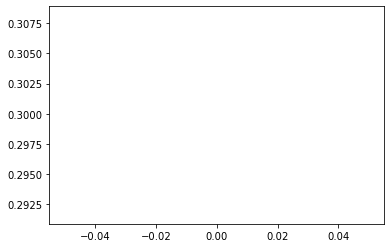

In [22]:
model = TwoLayerMLP(D_in, 50, D_out)
model.load_state_dict(torch.load('models/mod-%s.pth' % model.__class__.__name__))
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
num_epochs=10, log_interval=2)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

# Test several MLP architectures

In [23]:
class MLP(nn.Module):
    def __init__(self, d_layer):
        super(MLP, self).__init__()
        self.d_layer = d_layer
        layer_list = [nn.Linear(d_layer[l], d_layer[l+1]) for l in range(len(d_layer) - 1)]
        self.linears = nn.ModuleList(layer_list)
    def forward(self, X):
        X = X.view(-1, self.d_layer[0])
        # relu(Wl x) for all hidden layer
        for layer in self.linears[:-1]:
            X = F.relu(layer(X))
            # softmax(Wl x) for output layer
        return F.log_softmax(self.linears[-1](X), dim=1)

Epoch 0/9
----------
Epoch 2/9
----------
Epoch 4/9
----------
Epoch 6/9
----------
Epoch 8/9
----------
Training complete in 0m 26s
Best val Acc: 89.09%


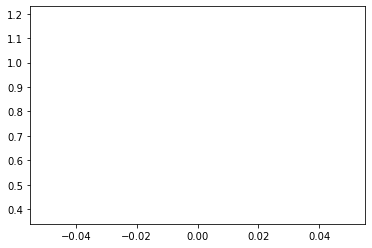

In [24]:
model = MLP([D_in, 512, 256, 128, 64, D_out]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
num_epochs=10, log_interval=2)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

# Reduce the size of training dataset

In [25]:
train_loader, val_loader = load_mnist(16, 1000)
train_size = 10 * 16
# Stratified sub-sampling
targets = train_loader.dataset.targets.numpy()
nclasses = len(set(targets))

In [26]:
indices = np.concatenate([np.random.choice(np.where(targets == lab)[0], int(train_size / nclasses),replace=False)
                          for lab in set(targets)])

In [27]:
np.random.shuffle(indices)
train_loader = torch.utils.data.DataLoader(train_loader.dataset, batch_size=16, 
                                           sampler=torch.utils.data.SubsetRandomSampler(indices))

In [28]:
# Check train subsampling
train_labels = np.concatenate([labels.numpy() for inputs, labels in train_loader])
print("Train size=", len(train_labels), " Train label count=", {lab:np.sum(train_labels == lab) for lab in set(train_labels)})
print("Batch sizes=", [inputs.size(0) for inputs, labels in train_loader])

Train size= 160  Train label count= {0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 16, 9: 16}
Batch sizes= [16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


In [29]:
# Put together train and val
dataloaders = dict(train=train_loader, val=val_loader)

In [30]:
# Info about the dataset
D_in = np.prod(dataloaders["train"].dataset.data.shape[1:])
D_out = len(dataloaders["train"].dataset.targets.unique())
print("Datasets shape", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features", D_in, "N output", D_out)

Datasets shape {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features 784 N output 10


In [31]:
model = MLP([D_in, 512, 256, 128, 64, D_out]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

Epoch 0/99
----------
Epoch 20/99
----------
Epoch 40/99
----------
Epoch 60/99
----------
Epoch 80/99
----------
Training complete in 0m 2s
Best val Acc: 13.07%


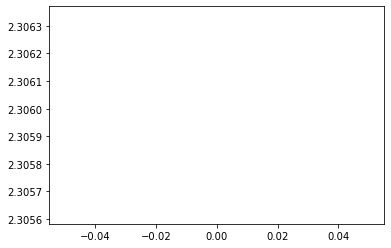

In [32]:
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
num_epochs=100, log_interval=20)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

Epoch 0/99
----------
Epoch 20/99
----------
Epoch 40/99
----------
Epoch 60/99
----------
Epoch 80/99
----------
Training complete in 0m 2s
Best val Acc: 45.68%


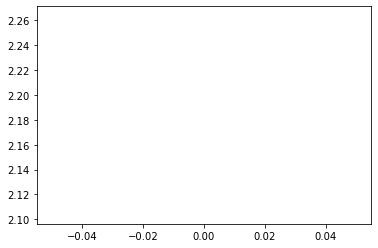

In [33]:
model = MLP([D_in, 512, 256, 128, 64, D_out]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
num_epochs=100, log_interval=20)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')